<a href="https://colab.research.google.com/github/dan-manolescu/data-structures-fun/blob/main/C7_Grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Grids and nearest neighbor scan**

## Nearest-Neighbor Search with Linear Scan

Classic example of linear scan through an array for the nearest neighbor for the given target. Uses a distance function (can be euclidean distance for example)

In [10]:
from typing import List, Callable

def LinearScanClosestNeighbor(A: List, target: float, dist: Callable) -> float:
    N = len(A)
    # First, check if the input array is empty (in that case there is no closest point).
    if N == 0:
        return None

    # The fist item in the array is the initial candidate to compute distance to target.
    candidate = A[0]
    closest_distance = dist(target, candidate)

    # Iterate over the rest of the array.
    for i in range(1, N):
        current_distance = dist(target, A[i])
        # Update the best candidate and best distance found.
        if current_distance < closest_distance:
            closest_distance = current_distance
            candidate = A[i]

    # Return the closest neighbor
    return candidate

## Grid structure

Helper functions:
*   Approximate equality between two points with float coordinates
*   Euclidean distance between two points





In [11]:
from math import sqrt

# threshold to be set based on desired numerical precision.
threshold = 0.0

def approx_equal(x1: float, y1: float, x2: float, y2: float) -> bool:
    '''
    Returns True if both points are wihin a threshold distance in both dimensions.
    '''
    if abs(x1 - x2) > threshold:
        return False
    if abs(y1 - y2) > threshold:
        return False
    return True

def euclidean_dist(x1: float, y1: float, x2: float, y2: float) -> float:
    return sqrt((x1 - x2)**2 + (y1 - y2)**2)

A class to represent a point in the grid.
Each point is part of a linked list of points, hence the *next* pointer as part of the class.
*x* and *y* represent the point x and y coordinates

In [12]:
class GridPoint:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
        self.next = None

A class to represent a grid.
A grid has a start and end positions on the x and y coordinates and it's split into a specified number of bins on the x and y coordinate.
The bins width on the x and on the y are calculated.

The grid class exposes methods to:
*   Insert points
*   Delete points
*   Linear search for a point inside all grid bins
*   Expanding search from an initial bin (more efficient search than linear)



In [13]:
class Grid:
    def __init__(self, x_start: float, x_end: float, y_start: float, y_end: float, num_x_bins: int, num_y_bins: int):
        self.num_x_bins = num_x_bins
        self.num_y_bins = num_y_bins
        self.x_start = x_start
        self.x_end = x_end
        self.x_bin_width = (self.x_end - self.x_start) / self.num_x_bins
        self.y_start = y_start
        self.y_end = y_end
        self.y_bin_width = (self.y_end - self.y_start) / self.num_y_bins
        self.bins = [[None for _ in range(self.num_y_bins)] for _ in range(self.num_x_bins)]

    def GridInsert(self, x: float, y: float) -> bool:
        # Compute the x and y bins for the new point.
        xbin = int((x - self.x_start) // self.x_bin_width)
        ybin = int((y - self.y_start) // self.y_bin_width)

        # Check that the point is within the grid.
        if xbin < 0 or xbin >= self.num_x_bins:
            return False
        if ybin < 0 or ybin >= self.num_y_bins:
            return False

        # Add the point to the front of the list.
        next_point = self.bins[xbin][ybin]
        self.bins[xbin][ybin] = GridPoint(x, y)
        self.bins[xbin][ybin].next = next_point

        # Confirm point was inserted into the grid.
        return True

    def GridDelete(self, x: float, y: float) -> bool:
        # Compute the x and y bins for the point to be deleted.
        xbin = int((x - self.x_start) // self.x_bin_width)
        ybin = int((y - self.y_start) // self.y_bin_width)

        # Check that the point is within the grid.
        if xbin < 0 or xbin >= self.num_x_bins:
            return False
        if ybin < 0 or ybin >= self.num_y_bins:
            return False

        # Check if the bin is empty.
        if self.bins[xbin][ybin] == None:
            return False

        # Find the first matching point and remove it.
        current = self.bins[xbin][ybin]
        previous = None
        while current != None:
            # Test each point using approx_equal function
            if approx_equal(x, y, current.x, current.y):
                # When it finds a matching point splice it out of the list
                # and make sure to correctly handle the special case of the first node in the list.
                if previous == None:
                    self.bins[xbin][ybin] = current.next
                else:
                    previous.next = current.next
                return True
            # If the current point doesn't match the search continues to the next node in the list.
            previous = current
            current = current.next
        # The function returns False if the search has finished the entire list
        # to indicate that no matching node was deleted.
        return False

    def MinDistToBin(self, xbin: int, ybin: int, x: float, y: float) -> float:
        '''
        A helper function that computes the closest distance from a target point to a given bin
        '''
        # Check that the bin is valid.
        if xbin < 0 or xbin >= self.num_x_bins:
            return float('Inf')
        if ybin < 0 or ybin >= self.num_y_bins:
            return float('Inf')

        # Compute he min and max values for the bin, compare them with the point value
        # on each dimension and compute the distance.
        x_min = self.x_start + xbin * self.x_bin_width
        x_max = self.x_start + (xbin + 1) * self.x_bin_width
        x_dist = 0
        if x < x_min:
            x_dist = x_min - x
        if x > x_max:
            x_dist = x - x_max

        y_min = self.y_start + ybin * self.y_bin_width
        y_max = self.y_start + (ybin + 1) * self.y_bin_width
        y_dist = 0
        if y < y_min:
            y_dist = y_min - y
        if y > y_max:
            y_dist = y - y_max

        return sqrt(x_dist**2 + y_dist**2)

    def GridLinearScanNN(self, x: float, y: float) -> GridPoint:
        '''
        Iterate through all the grid's bins using a linear scan and only check those
        that contain a potential nearest neighbor (inefficient but simple algo).
        '''
        # Start by setting the best distance to infinity (no best point has been found so far)
        best_dist = float('Inf')
        best_candidate = None

        # Then scan all bins.
        for xbin in range(self.num_x_bins):
            for ybin in range(self.num_y_bins):
                # Check if we need to process the bin.
                if self.MinDistToBin(xbin, ybin, x, y) < best_dist:
                    # Check every point in the bin's linked list.
                    current = self.bins[xbin][ybin]
                    while current != None:
                        dist = euclidean_dist(x, y, current.x, current.y)
                        # Compare every point distance with the bext distance found so far.
                        if dist < best_dist:
                            best_dist = dist
                            best_candidate = current
                        current = current.next

        return best_candidate

    def GridCheckBin(self, xbin: int, ybin: int, x: float, y: float, threshold: float) -> GridPoint:
        '''
        Helper function that checks whether any points within a specified bin are closer to our
        target point (x, y) than a given threshold.
        '''
        # First check we are accessing a valid bin.
        if xbin < 0 or xbin >= self.num_x_bins:
            return None
        if ybin < 0 or ybin >= self.num_y_bins:
            return None

        # Set best distance initially as threshold so it will only mark points less than it.
        best_candidate = None
        best_dist = threshold
        # Check each of the points in the bin one by one.
        current = self.bins[xbin][ybin]
        while current != None:
            # Compute distance to the target point and save it as the best candidate if it's closer.
            dist = euclidean_dist(x, y, current.x, current.y)
            if dist < best_dist:
                best_dist = dist
                best_candidate = current
            current = current.next

        return best_candidate

    def GridSearchExpanding(self, x: float, y: float) -> GridPoint:
        '''
        Expanding search in a diamond pattern by iterating through a different
        number of steps and checking all bins that can be reached in that number
        of steps.
        '''
        best_d = float('Inf')
        best_pt = None

        # Find the starting x and y bins for our search.
        xb = int((x - self.x_start) // self.x_bin_width)
        if xb < 0:
            xb = 0
        if xb >= self.num_x_bins:
            xb = self.num_x_bins - 1

        yb = int((y - self.y_start) // self.y_bin_width)
        if yb < 0:
            yb = 0
        if yb >= self.num_y_bins:
            yb = self.num_y_bins - 1

        steps = 0  # track the distance used for the current iteration
        explore = True  # indicate that the next iteration might contain a valid bin
        # Explore outward from the initial bin by increasing amounts.
        while explore:
            explore = False  # the loop will terminate when we complete a full iteration where no bins are valid

            # Iterate across different x-index offsets from -steps to +steps.
            for xoff in range(-steps, steps + 1):
                # Compute the remaining number of steps to use on the y-direction.
                yoff = steps - abs(xoff)
                # Check if the bin indices are valid and determine dist to that bin on negative y-direction.
                if self.MinDistToBin(xb + xoff, yb - yoff, x, y) < best_d:
                    # If the bin can contain a closer point than current candidate check it.
                    pt = self.GridCheckBin(xb + xoff, yb - yoff, x, y, best_d)
                    if pt != None:
                        best_d = euclidean_dist(x, y, pt.x, pt.y)
                        best_pt = pt
                    explore = True

                # Check now on positive y-direction.
                if self.MinDistToBin(xb + xoff, yb + yoff, x, y) < best_d and yoff != 0:
                    pt = self.GridCheckBin(xb + xoff, yb + yoff, x, y, best_d)
                    if pt != None:
                        best_d = euclidean_dist(x, y, pt.x, pt.y)
                        best_pt = pt
                    explore = True

            steps += 1

        return best_pt





Helper function to visualize the grid, target point or the nearest neighbor point in the grid

In [50]:
def visualize_grid(grid: Grid, target_pt: GridPoint=None, closest_pt: GridPoint=None) -> None:
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.grid(True)
    ax.set_aspect('equal')
    ax.set_xlabel('X-Coordinate')
    ax.set_ylabel('Y-Coordinate')
    ax.set_title('Grid with Points')

    ax.set_xlim(grid.x_start, grid.x_end)
    ax.set_ylim(grid.y_start, grid.y_end)
    xcells = [grid.x_start + i * grid.x_bin_width for i in range(grid.num_x_bins)]
    ycells = [grid.y_start + i * grid.y_bin_width for i in range(grid.num_y_bins)]
    ax.set_xticks(xcells)
    ax.set_yticks(ycells)

    x_coord = []
    y_coord = []
    for xbin in range(grid.num_x_bins):
        for ybin in range(grid.num_y_bins):
            current = grid.bins[xbin][ybin]
            while current != None:
                x_coord.append(current.x)
                y_coord.append(current.y)
                current = current.next

    # Add the target point if specified.
    if target_pt != None:
        x_coord.append(target_pt.x)
        y_coord.append(target_pt.y)

        ax.scatter(x_coord, y_coord, c=['blue']*(len(x_coord)-1) + ['red'])

        # If we've found the closest point then draw it as on a circle
        # with the center on the target point and a radius drawn between them.
        if closest_pt != None:
            ax.plot([target_pt.x, closest_pt.x], [target_pt.y, closest_pt.y], color='green', linestyle='-')
            circle = Circle((target_pt.x, target_pt.y),
                            euclidean_dist(target_pt.x, target_pt.y, closest_pt.x, closest_pt.y),
                            linestyle=':', fill=False, linewidth=2, color='green')
            ax.add_patch(circle)

    else:
        ax.scatter(x_coord, y_coord)

    plt.show()

Testing the Grid class with adding points

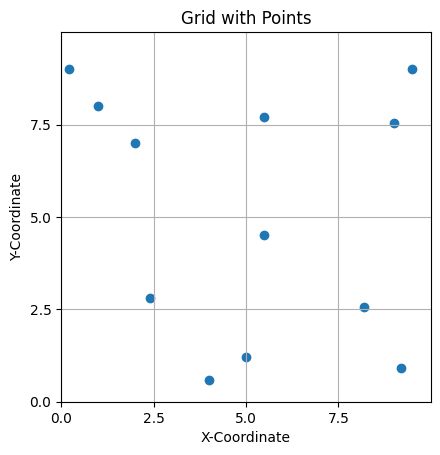

In [68]:
grid = Grid(0.0, 10.0, 0.0, 10.0, 4, 4)
grid.GridInsert(0.2, 9.0)
grid.GridInsert(1.0, 8.0)
grid.GridInsert(2.0, 7.0)
grid.GridInsert(2.4, 2.8)
grid.GridInsert(4.0, 0.6)
grid.GridInsert(5.0, 1.2)
grid.GridInsert(5.5, 4.5)
grid.GridInsert(8.2, 2.55)
grid.GridInsert(9.2, 0.9)
grid.GridInsert(9.0, 7.55)
grid.GridInsert(9.5, 9.0)
grid.GridInsert(5.5, 7.7)

visualize_grid(grid)

Delete a point from the grid

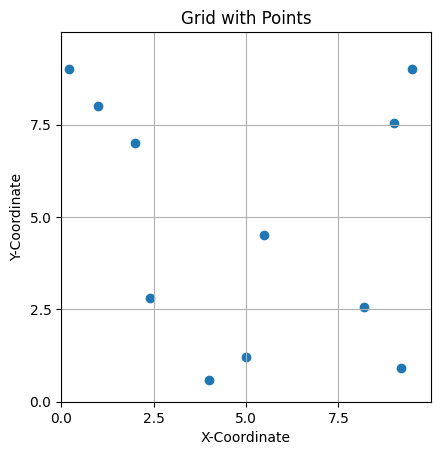

In [69]:
grid.GridDelete(5.5, 7.7)
visualize_grid(grid)

Demonstrate a target point and the closest neighbor found

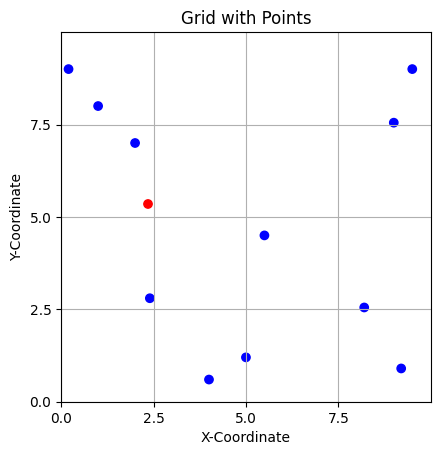

In [72]:
target_pt = GridPoint(2.35, 5.35)
visualize_grid(grid, target_pt)

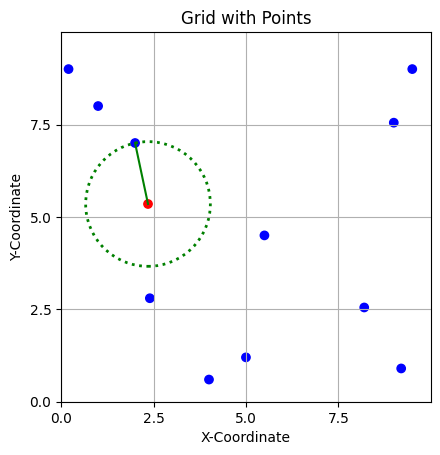

In [73]:
visualize_grid(grid, target_pt, grid.GridSearchExpanding(target_pt.x, target_pt.y))